In [1]:
import numpy as np
import gymnasium as gym
from collections import defaultdict  # required for creating Q(s, a)
from moviepy import ImageSequenceClip # to generate gif
from IPython.display import Image

import matplotlib 
#matplotlib.use('Qt5Agg') # Activte it if you want external plot for any interaction
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# We train our agent by SARSA in two following environments

envs = ['Taxi-v3', 'CliffWalking-v1']


In [3]:
# This functions are for visualization of episodes after training
# -------------------------
# Render Episodes Using RGB Frames
# -------------------------



def create_gif(frames, filename, fps=5):
    """Creates a GIF animation from a list of frames."""
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_gif(filename, fps=fps)

    
    
def run_multi_episodes(env, Q_table, run_num=10, epsilon=0):
    """Run a single episode using the learned Q-table."""
    total_frames = []
    total_reward = []
    for run in range(run_num):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        frames = [env.render()]

        while not done:
            action = np.argmax(Q_table[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            frames.append(env.render())
            episode_reward += reward
            state = next_state
        total_frames.extend(frames)
        total_reward.append(episode_reward)
    return total_frames, total_reward

In [4]:
def sarsa_update(Q_table, E, state, action, reward, next_state, next_action, alpha, gamma, lam):
    """
    Perform a backward-view SARSA(λ) update on the Q-table.

    Parameters:
    Q_table : numpy.ndarray
        The Q-value table with shape [num_states, num_actions].
    E : numpy.ndarray
        The eligibility trace table with the same shape as Q_table.
    state : int
        The current state.
    action : int
        The action taken in the current state.
    reward : float
        The immediate reward received after taking the action.
    next_state : int
        The next state reached after taking the action.
    next_action : int
        The next action chosen in the next state (SARSA uses on-policy update).
    alpha : float
        Learning rate (step size).
    gamma : float
        Discount factor for future rewards.
    lam : float
        Decay rate for the eligibility trace (λ parameter).
    """

    # 1️⃣ Compute the temporal-difference (TD) error.
    #    This measures the difference between the current estimate (Q[state, action])
    #    and the better estimate based on the observed reward and the next state-action pair.
    delta = reward + gamma * Q_table[next_state, next_action] - Q_table[state, action]

    # 2️⃣ Increment eligibility trace for the current state-action pair.
    #    This marks the pair as being "eligible" for learning updates.
    #    Each time a state-action pair is visited, its eligibility is increased.
    E[state, action] += 1

    # 3️⃣ Update all Q-values proportionally to their eligibility traces.
    #    The TD error is propagated backward to all previously visited state-action pairs.
    #    alpha controls how much we adjust Q-values.
    Q_table += alpha * delta * E

    # 4️⃣ Decay eligibility traces for all state-action pairs.
    #    Older traces fade away over time, controlled by γλ.
    #    This ensures recent experiences have a stronger effect.
    E *= gamma * lam


In [5]:
def epsilon_greedy(env, Q_table, state, epsilon):
    """
    Select an action using the epsilon-greedy policy.

    Parameters:
    env : gym.Env
        The environment, used here to sample a random action when exploring.
    Q_table : numpy.ndarray
        The Q-value table with shape [num_states, num_actions].
    state : int
        The current state.
    epsilon : float
        The exploration rate (0 ≤ epsilon ≤ 1). 
        With probability epsilon, choose a random action (exploration);
        otherwise, choose the best-known action (exploitation).

    Returns:
    action : int
        The action chosen according to the epsilon-greedy rule.
    """

    # 1️⃣ Generate a random number in [0, 1)
    #    This random draw decides whether the agent explores or exploits.
    if np.random.random() < epsilon:
        # 2️⃣ EXPLORATION:
        #     With probability ε, select a random action from the environment's action space.
        #     This encourages discovering new or less-visited actions.
        return env.action_space.sample()
    else:
        # 3️⃣ EXPLOITATION:
        #     With probability (1 - ε), select the action with the highest Q-value
        #     for the current state — the best known action according to current knowledge.
        return np.argmax(Q_table[state])


In [6]:
def Train_BarckwardViewSARSA(envIdx, episodes_num, printout, output_name, 
                alpha=0.1, gamma=0.99, epsilon=0.1, lam=0.05):
    """
    Train an agent using the SARSA(λ) algorithm with backward eligibility traces.

    Parameters:
    envIdx : int
        Index of the environment to train on (from the envs list).
    episodes_num : int
        Total number of training episodes.
    printout : int
        Interval (in episodes) at which training progress is printed.
    output_name : str
        Tag used in the output filenames for saving plots and animations.
    alpha : float
        Learning rate — how fast Q-values are updated.
    gamma : float
        Discount factor for future rewards.
    epsilon : float
        Initial exploration rate (for epsilon-greedy policy).
    lam : float
        Eligibility trace decay parameter (λ).

    The function trains the agent, logs rewards and episode lengths,
    plots metrics, and generates an animation of the trained policy.
    """

    # 1️⃣ Initialize the environment
    env = gym.make(envs[envIdx])

    # 2️⃣ Initialize Q-table with zeros (state × action)
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q_table = np.zeros((n_states, n_actions))
    print(f'Environment {envs[envIdx]}:\n'
          f'    Size of observation space: {n_states}\n'
          f'    Size of action space: {n_actions}')

    # Lists to store metrics for plotting
    episode_rewards = []
    episode_lengths = []

    # 3️⃣ Loop over all training episodes
    for episode in range(episodes_num):

        # Reset environment at the start of each episode
        state, _ = env.reset()

        # Choose initial action using epsilon-greedy strategy
        action = epsilon_greedy(env, Q_table, state, epsilon)

        # Initialize the eligibility traces to zero at the beginning of each episode
        E = np.zeros_like(Q_table)

        done = False
        total_reward = 0
        steps = 0

        # 4️⃣ Main episode loop
        while not done:
            # Take the chosen action and observe next state and reward
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Choose next action using epsilon-greedy policy (on-policy)
            next_action = epsilon_greedy(env, Q_table, next_state, epsilon)

            # 5️⃣ Update Q-values and eligibility traces using backward-view SARSA(λ)
            sarsa_update(Q_table, E, state, action, reward, next_state, next_action, alpha, gamma, lam)

            # Move to next step
            state = next_state
            action = next_action
            total_reward += reward
            steps += 1

        # 6️⃣ Log total reward and number of steps for the episode
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        # 7️⃣ Gradually decay epsilon to reduce exploration over time
        epsilon *= 0.99

        # 8️⃣ Print progress every 'printout' episodes
        if episode % printout == 0:
            avg_reward = np.mean(episode_rewards[-100:])  # rolling average
            avg_length = np.mean(episode_lengths[-100:])
            print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Avg Length: {avg_length:.2f}")

    # 9️⃣ After training — plot performance metrics
    plt.figure(figsize=(12, 5))

    # Plot total reward per episode
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title("Episode Return")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")

    # Plot episode length per episode
    plt.subplot(1, 2, 2)
    plt.plot(episode_lengths)
    plt.title("Episode Length")
    plt.xlabel("Episode")
    plt.ylabel("Number of Steps")

    plt.tight_layout()
    plt.savefig(f'learning_progress_{envs[envIdx]}_{output_name}.png', bbox_inches='tight', dpi=100)
    plt.close()

    # 🔟 Visualize the trained policy by running a few episodes
    env_vis = gym.make(envs[envIdx], render_mode='rgb_array')
    frames, total_reward = run_multi_episodes(env_vis, Q_table, run_num=5)

    # Create and save an animated GIF of the agent's behavior
    create_gif(frames, f"trained_{envs[envIdx]}_{output_name}.gif", fps=5)
    print(f"Episodes completed with total rewards: {total_reward}")

    env.close()


### Training for Taxi environment

In [7]:
# training the agent and visualizing some episodes for Taxi-v3 env

Train_BarckwardViewSARSA(0, 20000, 2500, '1', alpha=0.1, gamma=0.99, epsilon=0.1)

Environment Taxi-v3:
    Size of observation space: 500
    Size of action space: 6
Episode 0, Avg Reward: -578.00, Avg Length: 200.00
Episode 2500, Avg Reward: 7.96, Avg Length: 13.04
Episode 5000, Avg Reward: 8.17, Avg Length: 12.83
Episode 7500, Avg Reward: 7.96, Avg Length: 13.04
Episode 10000, Avg Reward: 7.81, Avg Length: 13.19
Episode 12500, Avg Reward: 8.18, Avg Length: 12.82
Episode 15000, Avg Reward: 7.62, Avg Length: 13.38
Episode 17500, Avg Reward: 7.85, Avg Length: 13.15
MoviePy - Building file trained_Taxi-v3_1.gif with imageio.


Episodes completed with total rewards: [9, 9, 8, 10, 14]


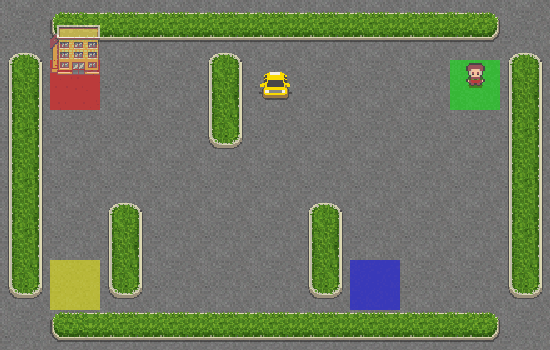

In [8]:
Image('./trained_Taxi-v3_1.gif')

<br><br>

### Training for CliffWalking

In [9]:
# training the agent and visualizing some episodes for CliffWalking-v1 env
# limit the exploration by 0.1
Train_BarckwardViewSARSA(1, 500, 50, 'eps_01', alpha=0.1, gamma=0.99, epsilon=0.1)

Environment CliffWalking-v1:
    Size of observation space: 48
    Size of action space: 4
Episode 0, Avg Reward: -89.00, Avg Length: 89.00
Episode 50, Avg Reward: -192.69, Avg Length: 115.04
Episode 100, Avg Reward: -130.56, Avg Length: 84.03
Episode 150, Avg Reward: -51.68, Avg Length: 41.78
Episode 200, Avg Reward: -31.36, Avg Length: 27.40
Episode 250, Avg Reward: -24.14, Avg Length: 21.17
Episode 300, Avg Reward: -19.24, Avg Length: 17.26
Episode 350, Avg Reward: -15.74, Avg Length: 15.74
Episode 400, Avg Reward: -15.32, Avg Length: 15.32
Episode 450, Avg Reward: -15.05, Avg Length: 15.05
MoviePy - Building file trained_CliffWalking-v1_eps_01.gif with imageio.


Episodes completed with total rewards: [-15, -15, -15, -15, -15]


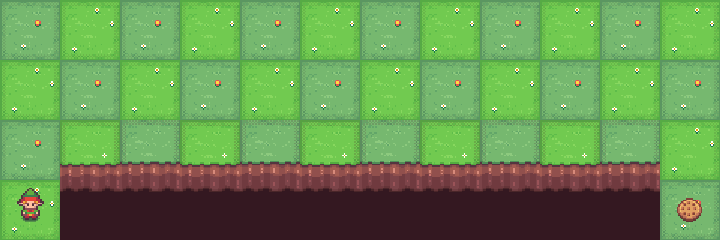

In [10]:
Image('./trained_CliffWalking-v1_eps_01.gif')

In [11]:
# training the agent and visualizing some episodes for CliffWalking-v1 env
# allow the exploration by 0.9
Train_BarckwardViewSARSA(1, 500, 50, 'eps_09', alpha=0.1, gamma=0.99, epsilon=0.9)

Environment CliffWalking-v1:
    Size of observation space: 48
    Size of action space: 4
Episode 0, Avg Reward: -18466.00, Avg Length: 2824.00
Episode 50, Avg Reward: -1150.10, Avg Length: 241.63
Episode 100, Avg Reward: -441.99, Avg Length: 114.30
Episode 150, Avg Reward: -63.55, Avg Length: 31.87
Episode 200, Avg Reward: -36.73, Avg Length: 22.87
Episode 250, Avg Reward: -23.75, Avg Length: 19.79
Episode 300, Avg Reward: -21.67, Avg Length: 18.70
Episode 350, Avg Reward: -20.97, Avg Length: 18.00
Episode 400, Avg Reward: -18.47, Avg Length: 17.48
Episode 450, Avg Reward: -18.31, Avg Length: 17.32
MoviePy - Building file trained_CliffWalking-v1_eps_09.gif with imageio.


Episodes completed with total rewards: [-17, -17, -17, -17, -17]


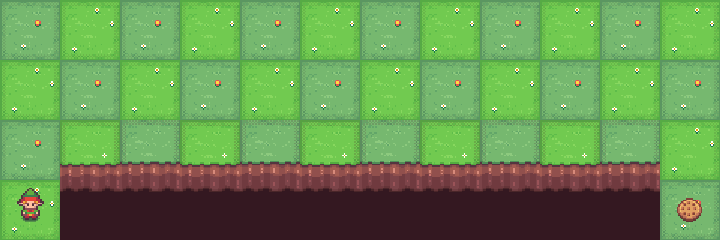

In [12]:
Image('./trained_CliffWalking-v1_eps_09.gif')